In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:
spikes=np.load('spikes.npy')
cell_identity=np.load('cell_identity.npy')[spikes>0]
spikes=spikes[spikes>0]

In [7]:
print(spikes)

[2.29000000e-01 4.26700000e+00 4.90000000e+00 ... 4.08338040e+06
 4.08338283e+06 4.08338647e+06]


In [8]:
start=time.time()
simulation_clock=Clock(dt = 0.01*ms)
defaultclock.dt = 0.01*ms
tau = 10*ms
vr = -70*mV
vt = -60*mV
Vth_i= -50.0*mV
Vr_i= -60.0*mV
eqs = '''
dv/dt = (I_ampa+I_gaba)/Cm : volt
I_ampa=-g_ext_ampa*s_ext*(v-E_ampa) : amp
I_gaba=-g_ext_gaba*s_gaba*(v-E_gaba) : amp
ds_ext/dt=-s_ext/t_ampa : 1
ds_gaba/dt = -s_gaba/t_gaba : 1
'''
eqs_i='''
dv/dt = (I_ampa+I_gaba)/Cm : volt
I_ampa=-g_ext_i*s_ext*(v-E_ampa) : amp
I_gaba=-g_gaba*s_gaba*(v-E_gaba) : amp
ds_ext/dt=-s_ext/t_ampa : 1
ds_gaba/dt = -s_gaba/t_gaba : 1
'''
t_ampa=2*ms
t_gaba= 10.0*ms
Cm= 0.5*nF
E_ampa=0.0*mV
E_gaba = -70.0*mV
g_ext_ampa=3.1*nS
g_gaba=1.024*nS
g_ext_gaba=1.34765625*nS
g_ext_i= 2.38*nS 
neuron = NeuronGroup(100, eqs, threshold='v>vt', reset='v=vr')
neuron_inh=NeuronGroup(50,eqs_i,threshold='v>Vth_i', reset='v=Vr_i')
neuron.v = E_ampa
neuron_inh.v=E_gaba
neuron.s_ext = 0
neuron_inh.s_ext = 0
neuron_inh.s_gaba = 0
spikes_gen=SpikeGeneratorGroup(1000,list(cell_identity),spikes*ms)
w = 1
S1 = Synapses(spikes_gen, neuron, on_pre='s_ext += 0.25')
S1.connect(p=0.1)
S2 = Synapses(neuron, neuron, on_pre='s_ext += 0.25')
S2.connect(p=0.5)
S3 = Synapses(neuron_inh, neuron, on_pre='s_gaba += 1.0')
S3.connect(p=0.5)
S4 = Synapses(neuron_inh, neuron_inh, on_pre='s_gaba += 1.0')
S4.connect(p=0.25)
S5 = Synapses(spikes_gen, neuron_inh, on_pre='s_ext += 0.25')
S5.connect(p=0.1)
S6 = Synapses(neuron, neuron_inh, on_pre='s_ext += 0.25')
S6.connect(p=0.5)
# Record the spikes
Mgp = SpikeMonitor(neuron)
Minput = SpikeMonitor(spikes_gen)
pop=PopulationRateMonitor(spikes_gen)
I_ampa_lst=[]
I_gaba_lst=[]
@network_operation(simulation_clock,when='start')
def update_nmda(simulation_clock):
    I_ampa=np.sum(neuron.I_ampa[:])
    I_gaba=np.sum(neuron.I_gaba[:])
    I_ampa_lst.append(I_ampa)
    I_gaba_lst.append(I_gaba)
duration=10000*ms
run(duration)
end=time.time()
print(end-start)

INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.01s, trying other methods took 0.03s). [brian2.stateupdaters.base.method_choice]


7532.20762014389


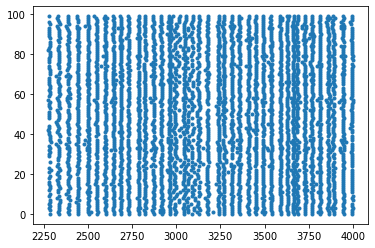

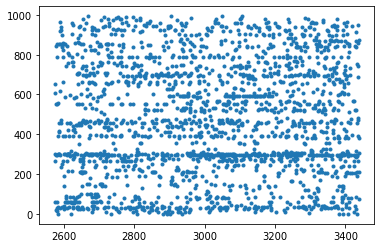

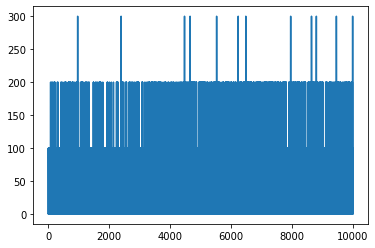

In [10]:
plot(Mgp.t[4000:8000]/ms, Mgp.i[4000:8000], '.')
plt.show()
plot(Minput.t[4000:6000]/ms,Minput.i[4000:6000],'.')
plt.show()
plot(pop.t/ms, pop.rate/Hz)